## Importing Libraries

In [1]:
import pandas as pd
from pypfopt.expected_returns import mean_historical_return
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import discrete_allocation
from pypfopt import expected_returns
from pypfopt import risk_models
from pypfopt import EfficientFrontier
from pypfopt import objective_functions
from pypfopt import base_optimizer
from pypfopt.discrete_allocation import DiscreteAllocation
from pypfopt.hierarchical_portfolio import HRPOpt

## Getting the Data

In [2]:
start_date = '2022-07-01'
end_date = '2023-06-30'

# Define the ticker list
tickers_list = ['AAPL', 'WMT', 'MU', 'BA','GOOG','BABA','GE','AMD','BAC','GM','T','UAA','XOM','RRC','PFE','JPM','SBUX']

# Fetch the data
import yfinance as yf
data = yf.download(tickers_list, start=start_date, end=end_date)['Adj Close']
#print(data.iloc[-1])
# Print first 5 rows of the data
#print(data.head())
#print(data.tail())

[*********************100%***********************]  17 of 17 completed


## Markowitz with Sharpe maximization

In [3]:
# Prepare historical price data for assets
#historical_prices = pd.read_csv('historical_prices.csv', index_col=0, parse_dates=True)
historical_prices = data
#target_volatility = 0.2


# Calculate expected returns
returns = expected_returns.mean_historical_return(historical_prices)
cov_matrix = risk_models.sample_cov(historical_prices)

# Create an instance of EfficientFrontier
ef = EfficientFrontier(returns, cov_matrix,weight_bounds = (0,0.2))

# Efficient Frontier with random portfolios

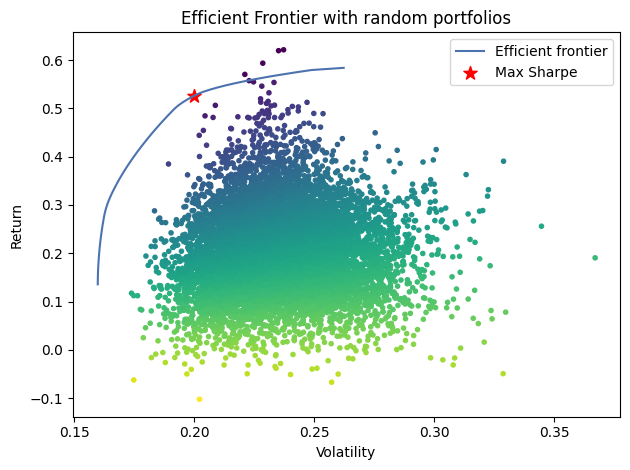

In [4]:
import pypfopt.plotting as plotting
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
ef_max_sharpe = ef.deepcopy()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

# Find the tangency portfolio
ef_max_sharpe.max_sharpe()
ret_tangent, std_tangent, _ = ef_max_sharpe.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

# Generate random portfolios
n_samples = 10000
w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
rets = w.dot(ef.expected_returns)
stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Output
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
#Saves the output file as a transparent image
plt.savefig("ef_scatter.png", dpi=200, transparent=True)
plt.show()

In [5]:
# Print Weights - Max Sharpe
cleaned_weights = ef_max_sharpe.clean_weights()
print(cleaned_weights)

OrderedDict([('AAPL', 0.16082), ('AMD', 0.0), ('BA', 0.18547), ('BABA', 0.0), ('BAC', 0.0), ('GE', 0.2), ('GM', 0.0), ('GOOG', 0.0), ('JPM', 0.10193), ('MU', 0.0), ('PFE', 0.0), ('RRC', 0.0), ('SBUX', 0.06276), ('T', 0.0), ('UAA', 0.0), ('WMT', 0.2), ('XOM', 0.08902)])


## Portfolio Performance - Max Sharpe

In [6]:
#to know the expected performance of the portfolio with optimal weights w
ef_max_sharpe.portfolio_performance(verbose=True)

Expected annual return: 52.6%
Annual volatility: 20.0%
Sharpe Ratio: 2.53


(0.5258063975112285, 0.19977306714806392, 2.531904849497779)

## Optimal Allocation

In [7]:
# Calculate the discrete allocation of assets based on the optimal weights
latest_prices = historical_prices.iloc[-1]  # Latest prices for the assets
da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=10000)
allocation, leftover = da.lp_portfolio()

/home/bhavya/anaconda3/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [8]:
print("Optimal Allocation:", allocation)

Optimal Allocation: {'AAPL': 8, 'BA': 9, 'GE': 19, 'JPM': 7, 'SBUX': 6, 'WMT': 13, 'XOM': 8}


## Comparison with Benchmark Chart

[*********************100%***********************]  1 of 1 completed


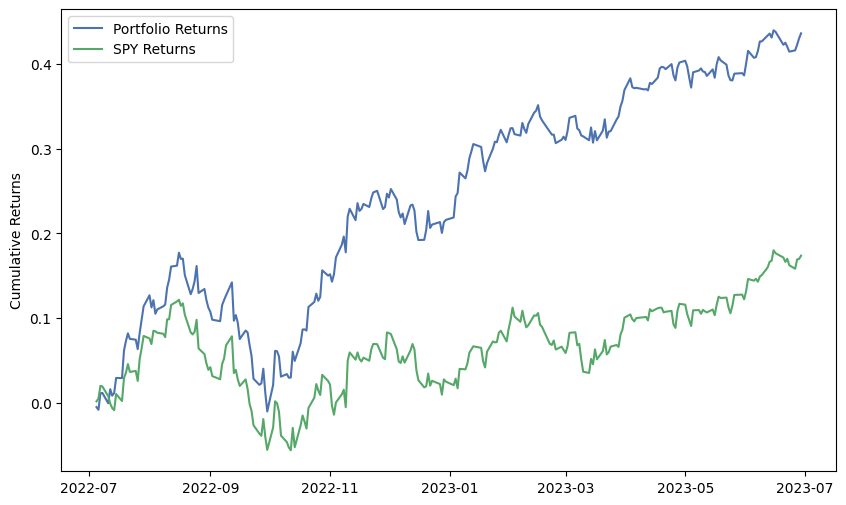

In [9]:
# Download benchmark data
spy_data = yf.download('SPY', start=start_date, end=end_date)['Adj Close']

# Calculate portfolio and benchmark returns
portfolio_returns = (historical_prices.pct_change().dropna() * cleaned_weights).sum(axis=1)
benchmark_returns = spy_data.pct_change().dropna()

# Plot the returns
plt.figure(figsize=(10, 6), facecolor='none')
plt.plot(portfolio_returns.cumsum(), label='Portfolio Returns')
plt.plot(benchmark_returns.cumsum(), label='SPY Returns')
plt.legend()
#plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
#plt.title('Portfolio Returns vs SPY Returns')
# Remove background grid lines
plt.grid(visible=False)
plt.savefig('portfolio_vs_spy.png', transparent=True)

## Markowitz with Target Volatility

In [10]:
# Prepare historical price data for assets
#historical_prices = pd.read_csv('historical_prices.csv', index_col=0, parse_dates=True)
historical_prices = data
target_volatility = 0.2


# Calculate expected returns
returns = expected_returns.mean_historical_return(historical_prices)
cov_matrix = risk_models.sample_cov(historical_prices)

# Create an instance of EfficientFrontier
ef_tv = EfficientFrontier(returns, cov_matrix,weight_bounds = (0,0.2))

ef_tv.efficient_risk(target_volatility)

# Optimize for maximum Sharpe ratio
#weights = ef.max_sharpe()

#  print weights
cleaned_weights_tv = ef_tv.clean_weights()
print(cleaned_weights)

OrderedDict([('AAPL', 0.16082), ('AMD', 0.0), ('BA', 0.18547), ('BABA', 0.0), ('BAC', 0.0), ('GE', 0.2), ('GM', 0.0), ('GOOG', 0.0), ('JPM', 0.10193), ('MU', 0.0), ('PFE', 0.0), ('RRC', 0.0), ('SBUX', 0.06276), ('T', 0.0), ('UAA', 0.0), ('WMT', 0.2), ('XOM', 0.08902)])


In [11]:
#to know the expected performance of the portfolio with optimal weights w
ef_tv.portfolio_performance(verbose=True)

Expected annual return: 52.6%
Annual volatility: 20.0%
Sharpe Ratio: 2.53


(0.5263782519891361, 0.20000000012201877, 2.5318912584009894)

In [12]:
# Calculate the discrete allocation of assets based on the optimal weights
latest_prices = historical_prices.iloc[-1]  # Latest prices for the assets
da = DiscreteAllocation(cleaned_weights_tv, latest_prices, total_portfolio_value=10000)
allocation_tv, leftover = da.lp_portfolio()

/home/bhavya/anaconda3/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [13]:
print("Optimal Allocation:", allocation_tv)

Optimal Allocation: {'AMD': 1, 'BA': 9, 'BABA': 1, 'BAC': 3, 'GE': 19, 'GM': 3, 'GOOG': 1, 'JPM': 8, 'MU': 2, 'PFE': 3, 'RRC': 3, 'SBUX': 7, 'T': 7, 'UAA': 39, 'WMT': 13, 'XOM': 9}


## Markowitz with Monthly Rebalancing keeping Original Weights Only

Currently getting ValueError: at least one of the assets must have an expected return exceeding the risk-free rate


In [14]:
# Create an empty DataFrame to store allocation results
allocation_history = pd.DataFrame(columns=tickers_list)

# Set initial portfolio value
portfolio_value = 10000

# Set rebalancing frequency (in months)
rebalancing_frequency = 1

# Iterate over each month
for i in range(0, len(historical_prices), rebalancing_frequency):
    # Get historical prices for the current month
    prices = historical_prices.iloc[i:i+rebalancing_frequency]

    # Calculate expected returns and covariance matrix
    returns = expected_returns.mean_historical_return(prices)
    cov_matrix = risk_models.sample_cov(prices)

    # Create an instance of EfficientFrontier
    ef = EfficientFrontier(returns, cov_matrix, weight_bounds=(0, 0.2))

    # Optimize for maximum Sharpe ratio
    weights = ef.max_sharpe()

    # Clean the weights for assets below the lower weight bound
    cleaned_weights = ef.clean_weights()

    # Calculate the discrete allocation of assets based on the optimal weights
    latest_prices = prices.iloc[-1]  # Latest prices for the assets
    da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=portfolio_value)
    allocation, _ = da.lp_portfolio()

    # Store the allocation for the current month
    allocation_history = allocation_history.append(allocation, ignore_index=True)

# Print the allocation history
print(allocation_history)

/home/bhavya/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/bhavya/.local/lib/python3.10/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/bhavya/.local/lib/python3.10/site-packages/pandas/core/frame.py:10222: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/home/bhavya/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/bhavya/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


ValueError: at least one of the assets must have an expected return exceeding the risk-free rate

### Test // Combining all above approaches into a single function

In [ ]:
def optimize_portfolio(historical_prices, objective, target=None, rebalance=False):
    # Calculate expected returns
    returns = expected_returns.mean_historical_return(historical_prices)
    cov_matrix = risk_models.sample_cov(historical_prices)

    # Create an instance of EfficientFrontier
    ef = EfficientFrontier(returns, cov_matrix, weight_bounds=(0, 0.2))

    if objective == "max_sharpe":
        # Optimize for maximum Sharpe ratio
        weights = ef.max_sharpe()
    elif objective == "target_volatility":
        # Optimize for target volatility
        ef.efficient_risk(target)
        weights = ef.clean_weights()
    else:
        raise ValueError("Invalid optimization objective. Please choose 'max_sharpe' or 'target_volatility'.")

    # Print weights
    cleaned_weights = ef.clean_weights()
    print(cleaned_weights)

    # Portfolio performance
    ef.portfolio_performance(verbose=True)

    # Calculate the discrete allocation of assets based on the optimal weights
    latest_prices = historical_prices.iloc[-1]  # Latest prices for the assets
    da = discrete_allocation.DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=10000)
    allocation, leftover = da.lp_portfolio()

    print("Optimal Allocation:", allocation)

    if rebalance:
        # Rebalance monthly
        rebalance_date = historical_prices.index[-1] + timedelta(days=30)
        historical_prices_rebalanced = historical_prices.loc[:rebalance_date]
        optimize_portfolio(historical_prices_rebalanced, objective, target, rebalance=True)


# Getting the Data
tickers_list = ['AAPL', 'WMT', 'MU', 'BA', 'GOOG', 'BABA', 'GE', 'AMD', 'BAC', 'GM', 'T', 'UAA', 'XOM', 'RRC', 'PFE', 'JPM',
                'SBUX']
data = yf.download(tickers_list, '2022-6-1')['Adj Close']

# Markowitz with Sharpe maximization
historical_prices = data
optimize_portfolio(historical_prices, objective="max_sharpe", rebalance=False)

# Markowitz with Target Volatility
historical_prices = data
target_volatility = 0.2
optimize_portfolio(historical_prices, objective="target_volatility", target=target_volatility, rebalance=True)

## Markowitz with Monthly Rebalancing - With Original Weights Revising every 12 months